In [ ]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [ ]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 88% 106M/121M [00:00<00:00, 168MB/s] 
100% 121M/121M [00:00<00:00, 151MB/s]


In [ ]:
from zipfile import ZipFile
zf = ZipFile('face-expression-recognition-dataset.zip', 'r')
zf.extractall('/content')
zf.close()

In [ ]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense,  Input, Flatten, Activation
#tf.keras.layers.MaxPooling2D
import tensorflow as tf

In [ ]:
classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
training_path='/content/images/train'
count_train=0
print("here are the number of images in the training classes")
for i in classes:
  print(i,": ", len(os.listdir(os.path.join(training_path, i))))
  count_train+=len(os.listdir(os.path.join(training_path, i)))

print("count= ", count_train)

here are the number of images in the training classes
angry :  3993
disgust :  436
fear :  4103
happy :  7164
neutral :  4982
sad :  4938
surprise :  3205
count=  28821


In [ ]:
validation_path='/content/images/validation'
print("here are the number of images in the training classes")
for i in classes:
  print(i,": ", len(os.listdir(os.path.join(validation_path, i))))

here are the number of images in the training classes
angry :  960
disgust :  111
fear :  1018
happy :  1825
neutral :  1216
sad :  1139
surprise :  797


In [ ]:
def random_sample_images(path, state):
  all_images = os.listdir(os.path.join(path,state))
  display_images = random.sample(all_images, 5)

  fig = plt.figure(figsize=(20, 7))

  for index, image_name in enumerate(display_images):
    img_path = os.path.join(path, state, image_name)
    img = cv2.imread(img_path)
    fig.add_subplot(1,5, index+1)
    plt.imshow(img)
    plt.title(f" {state} : {index+1}")

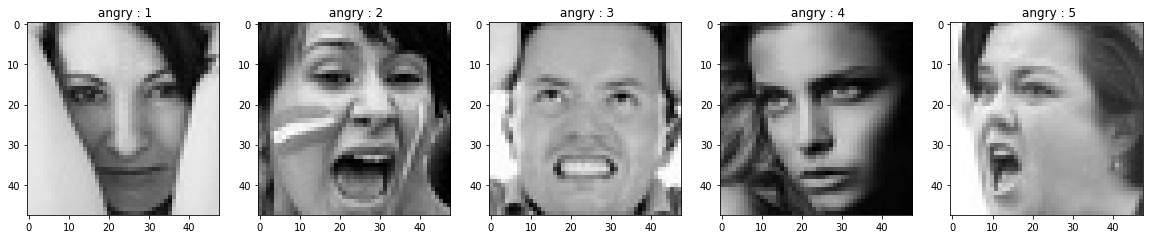

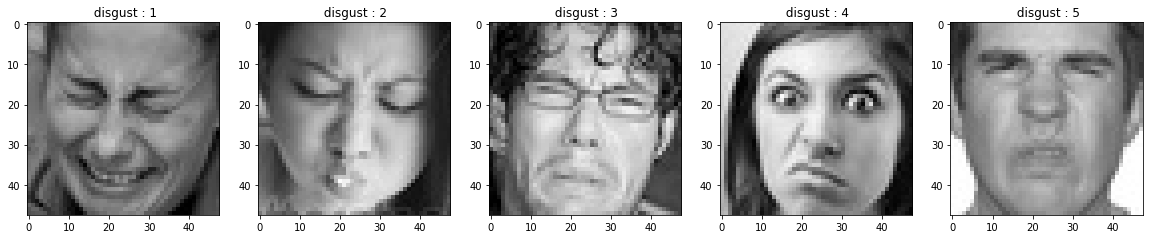

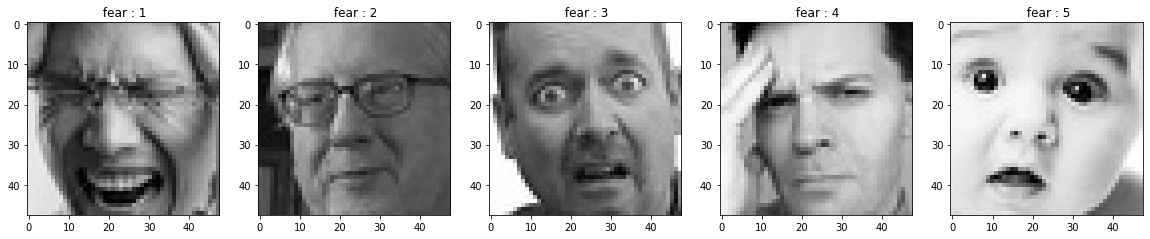

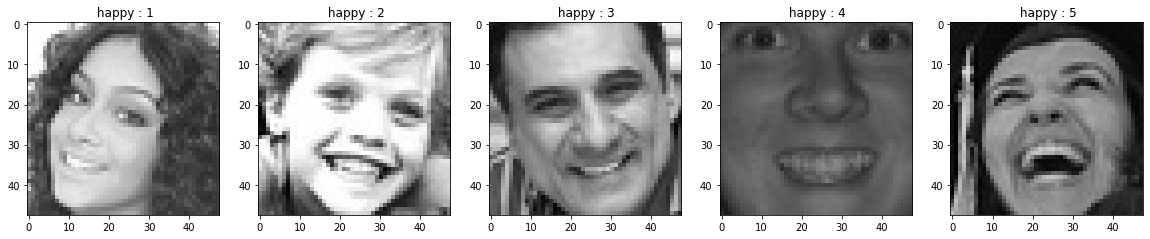

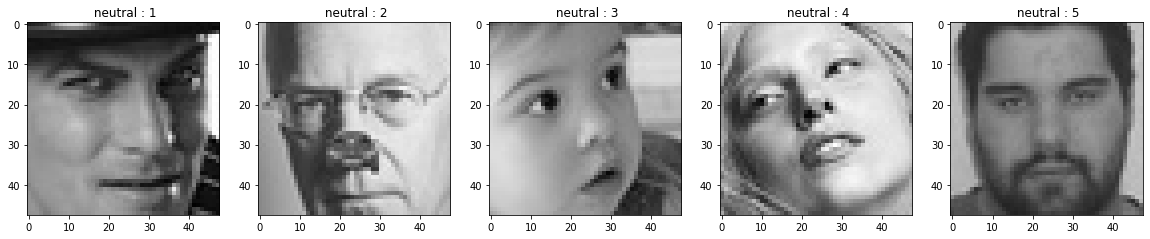

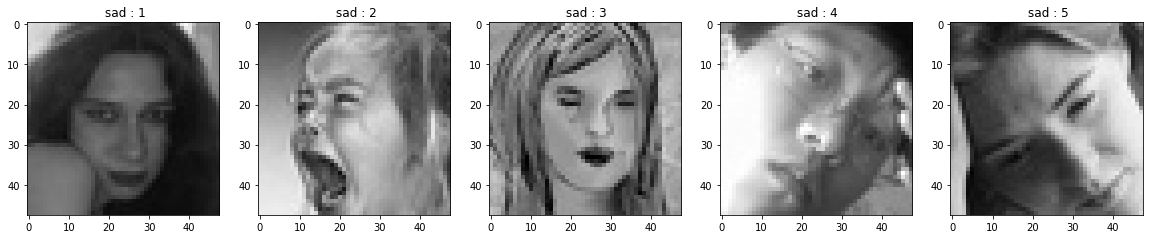

In [ ]:
random_sample_images(training_path,"angry")
random_sample_images(training_path,"disgust")
random_sample_images(training_path,"fear")
random_sample_images(training_path,"happy")
random_sample_images(training_path,"neutral")
random_sample_images(training_path,"sad")



In [ ]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale = 1./255)

train_generator = datagen.flow_from_directory(
	training_path,
	target_size=(224, 224),
  classes = classes,
	class_mode='categorical',
  shuffle=True
)

val_generator = datagen.flow_from_directory(
	validation_path,
	target_size=(224, 224),
  classes = classes,
	class_mode='categorical',
  shuffle=False
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


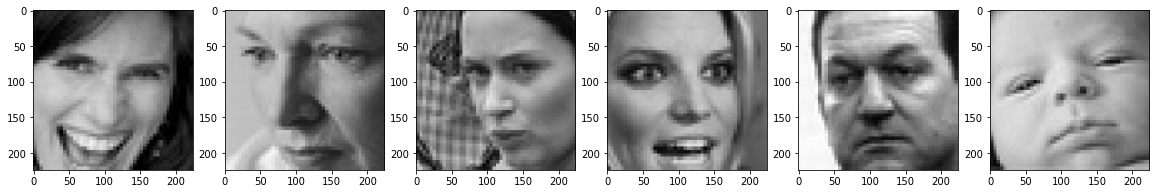

In [ ]:
x_train,y_train = next(train_generator)

plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(1,6,i+1)
    print(np.array(x_train[i]).shape)
    plt.imshow(x_train[i])

In [ ]:
model=tf.keras.applications.MobileNetV2()


def  build_pretr_model():
  model=tf.keras.applications.MobileNetV2()

  base_input= model.layers[0].input
  base_output=model.layers[-2].output

  final_output=Dense(128)(base_output )
  final_output= Activation('relu')(final_output)
  final_output=Dense(64)(final_output)
  final_output= Activation('relu')(final_output)
  final_output=Dense(len(classes), activation='softmax')(final_output)

  new_model=Model(inputs=base_input, outputs=final_output)

  #print(model.summary())

  new_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall() ])


  return new_model

pretr_model=build_pretr_model()

history = pretr_model.fit(train_generator, epochs=20, validation_data = val_generator, verbose = 1)


Epoch 1/20
901/901 [==============================] - 208s 225ms/step - loss: 1.2471 - accuracy: 0.5312 - precision_4: 0.7279 - recall_4: 0.3329 - val_loss: 3.2718 - val_accuracy: 0.4311 - val_precision_4: 0.4488 - val_recall_4: 0.4198
Epoch 2/20
901/901 [==============================] - 201s 223ms/step - loss: 1.0752 - accuracy: 0.5955 - precision_4: 0.7450 - recall_4: 0.4341 - val_loss: 2.0027 - val_accuracy: 0.4403 - val_precision_4: 0.4764 - val_recall_4: 0.3944
Epoch 3/20
901/901 [==============================] - 201s 223ms/step - loss: 1.0020 - accuracy: 0.6264 - precision_4: 0.7510 - recall_4: 0.4825 - val_loss: 2.3693 - val_accuracy: 0.4053 - val_precision_4: 0.4335 - val_recall_4: 0.3831
Epoch 4/20
901/901 [==============================] - 201s 223ms/step - loss: 0.9427 - accuracy: 0.6469 - precision_4: 0.7620 - recall_4: 0.5170 - val_loss: 2.5323 - val_accuracy: 0.3323 - val_precision_4: 0.3839 - val_recall_4: 0.2806
Epoch 5/20
901/901 [==============================] - 20

In [ ]:
!pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

model_for_export = tfmot.sparsity.keras.strip_pruning(pretr_model)
model_for_export.summary()

keras_file = 'fac_emot_rec_pretr.h5'
tf.keras.models.save_model(model_for_export, keras_file, include_optimizer=False)
print('Saved Keras model to:', keras_file)

     |████████████████████████████████| 237 kB 6.9 MB/s 
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[1][0]']                  
                                )  

In [ ]:
from tensorflow.keras.layers import Layer, Conv2D, Dense,  Input, Flatten,MaxPooling2D

model = tf.keras.models.Sequential([
    Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(classes), activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall() ])
history = model.fit(train_generator, epochs=20, validation_data = val_generator, verbose = 1)

Epoch 1/20


KeyboardInterrupt: ignored

In [ ]:
!pip install -q tensorflow-model-optimization 

In [ ]:
!pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

model_for_export = tfmot.sparsity.keras.strip_pruning(model)
model_for_export.summary()

keras_file = 'strip_facial_emot_rec.h5'
tf.keras.models.save_model(model_for_export, keras_file, include_optimizer=False)
print('Saved Keras model to:', keras_file)